# 安装和加载所需的 R 包

首先，我们需要确保所有必要的 R 包都已安装并加载。这些包包括 `zipfR`, `ggplot2`, `stringr`, `scales`, `tibble`, `dplyr`, `gss`, `nortest` 和 `tidyr`。


In [9]:
required_packages <- c("zipfR", "ggplot2", "stringr", "scales", "tibble", "dplyr", "gss", "nortest", "tidyr")

install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package, dependencies = TRUE)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(required_packages, install_and_load))


Loading required package: zipfR

Loading required package: ggplot2

Loading required package: scales

Loading required package: tibble

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: gss

Loading required package: nortest

Loading required package: tidyr



# 设置文件路径并读取文件

我们将设置包含 `.txt` 文件的文件夹路径，并识别所有这些文件。


In [10]:
folder_path <- "output_txt_files"
files <- list.files(folder_path, pattern = "\\.txt$", full.names = TRUE)


# 初始化结果数据框并处理每个文件

我们将初始化一个空的数据框来存储结果，并处理每个文件。


In [11]:
results <- data.frame(File = character(), Type = character(), Model = character(), Rank = numeric(), Frequency = numeric(), stringsAsFactors = FALSE)

process_file <- function(file) {
  text <- tolower(readLines(file, warn = FALSE))
  text <- unlist(strsplit(text, "\\W+"))
  freq <- sort(table(text), decreasing = TRUE)

  file_info <- str_match(basename(file), "(.*) (.*)\\d_responses.txt")
  if (length(file_info) < 3) return(NULL)

  temp_df <- data.frame(File = basename(file), Type = file_info[3], Model = file_info[2], Rank = seq_along(freq), Frequency = as.numeric(freq), stringsAsFactors = FALSE)

  return(temp_df)
}

results <- do.call(rbind, lapply(files, process_file))
print(results)


                                            File     Type              Model
1               Deepseek 创意写作1_responses.txt 创意写作           Deepseek
2               Deepseek 创意写作1_responses.txt 创意写作           Deepseek
3               Deepseek 创意写作1_responses.txt 创意写作           Deepseek
4               Deepseek 创意写作1_responses.txt 创意写作           Deepseek
5               Deepseek 创意写作1_responses.txt 创意写作           Deepseek
6               Deepseek 创意写作1_responses.txt 创意写作           Deepseek
7               Deepseek 创意写作1_responses.txt 创意写作           Deepseek
8               Deepseek 创意写作1_responses.txt 创意写作           Deepseek
9               Deepseek 创意写作1_responses.txt 创意写作           Deepseek
10              Deepseek 创意写作1_responses.txt 创意写作           Deepseek
11              Deepseek 创意写作1_responses.txt 创意写作           Deepseek
12              Deepseek 创意写作1_responses.txt 创意写作           Deepseek
13              Deepseek 创意写作1_responses.txt 创意写作           Deepseek
14              Deepseek 创

# 进行 Zipf-Mandelbrot 拟合

我们将对每个文件进行 Zipf-Mandelbrot 分布的拟合。


In [12]:
fit_results <- list()
parameters <- data.frame(File = character(), Model = character(), Type = character(), alpha = numeric(), B = numeric(), C = numeric(), X2 = numeric(), df = numeric(), p = numeric(), stringsAsFactors = FALSE)

process_spc_fit <- function(file) {
  data <- subset(results, File == file)
  N <- sum(data$Frequency)
  V <- length(data$Frequency)
  Vm <- table(data$Frequency)
  m <- as.numeric(names(Vm))

  file_info <- str_match(basename(file), "(.*) (.*)\\d_responses.txt")
  if (length(file_info) < 3) return(NULL)

  spc_obj <- tryCatch({
    spc(N = N, V = V, Vm = as.numeric(Vm), m = m)
  }, error = function(e) {
    message(paste("Error in spc function:", e))
    NULL
  })

  if (!is.null(spc_obj)) {
    fit <- tryCatch({
      lnre("zm", spc_obj)
    }, error = function(e) {
      message(paste("Error in lnre function:", e))
      NULL
    })

    if (!is.null(fit)) {
      alpha <- fit$param$alpha
      B <- fit$param$B
      C <- if ("C" %in% names(fit$param)) fit$param$C else NA
      X2 <- fit$gof$X2
      df <- fit$gof$df
      p <- fit$gof$p

      parameters <<- rbind(parameters, data.frame(File = basename(file), Model = file_info[2], Type = file_info[3], alpha = alpha, B = B, C = C, X2 = X2, df = df, p = p, stringsAsFactors = FALSE))

      fit_results[[file]] <<- fit
    } else {
      parameters <<- rbind(parameters, data.frame(File = basename(file), Model = file_info[2], Type = file_info[3], alpha = NA, B = NA, C = NA, X2 = NA, df = NA, p = NA, stringsAsFactors = FALSE))
    }
  } else {
    parameters <<- rbind(parameters, data.frame(File = basename(file), Model = file_info[2], Type = file_info[3], alpha = NA, B = NA, C = NA, X2 = NA, df = NA, p = NA, stringsAsFactors = FALSE))
  }
}

invisible(lapply(unique(results$File), process_spc_fit))
print(parameters)
write.csv(parameters, "fitting_parameters.csv", row.names = FALSE)


                                         File              Model     Type
1            Deepseek 创意写作1_responses.txt           Deepseek 创意写作
2            Deepseek 创意写作2_responses.txt           Deepseek 创意写作
3            Deepseek 感情咨询1_responses.txt           Deepseek 感情咨询
4            Deepseek 感情咨询2_responses.txt           Deepseek 感情咨询
5            Deepseek 技术问答1_responses.txt           Deepseek 技术问答
6            Deepseek 技术问答2_responses.txt           Deepseek 技术问答
7              GPT3.5 创意写作1_responses.txt             GPT3.5 创意写作
8              GPT3.5 创意写作2_responses.txt             GPT3.5 创意写作
9              GPT3.5 感情咨询1_responses.txt             GPT3.5 感情咨询
10             GPT3.5 感情咨询2_responses.txt             GPT3.5 感情咨询
11             GPT3.5 技术问答1_responses.txt             GPT3.5 技术问答
12             GPT3.5 技术问答2_responses.txt             GPT3.5 技术问答
13              GPT4o 创意写作1_responses.txt              GPT4o 创意写作
14              GPT4o 创意写作2_responses.txt              GPT4o 创意写作
15

# 计算不同模型和类型的参数均值和标准差


In [18]:

# 计算均值和标准差
summary_stats <- parameters %>%
  group_by(Model, Type) %>%
  summarise(alpha_mean = mean(alpha, na.rm = TRUE),
            alpha_sd = sd(alpha, na.rm = TRUE),
            B_mean = mean(B, na.rm = TRUE),
            B_sd = sd(B, na.rm = TRUE))

print(summary_stats)


`summarise()` has grouped output by 'Model'. You can override using the
`.groups` argument.


# A tibble: 15 × 6
# Groups:   Model [5]
   Model              Type     alpha_mean alpha_sd B_mean      B_sd
   <chr>              <chr>         <dbl>    <dbl>  <dbl>     <dbl>
 1 Deepseek           创意写作   6.29e- 1 2.39e- 2 0.0201 0.00371  
 2 Deepseek           感情咨询   1.52e- 1 1.48e- 2 0.0136 0.0000817
 3 Deepseek           技术问答   2.90e- 1 5.55e- 2 0.0212 0.00489  
 4 GPT3.5             创意写作   5.84e- 1 5.42e- 2 0.0224 0.000867 
 5 GPT3.5             感情咨询   3.45e- 1 3.84e- 3 0.0174 0.00202  
 6 GPT3.5             技术问答   3.95e- 1 1.41e- 2 0.0295 0.000990 
 7 GPT4o              创意写作   6.03e- 1 5.73e- 2 0.0163 0.00214  
 8 GPT4o              感情咨询   3.72e- 1 7.72e- 2 0.0139 0.000517 
 9 GPT4o              技术问答   3.99e- 1 8.92e- 2 0.0184 0.00465  
10 qwen2-72b-instruct 创意写作   4.33e- 1 1.89e- 1 0.0175 0.00157  
11 qwen2-72b-instruct 感情咨询   2.18e- 1 8.20e- 2 0.0121 0.000731 
12 qwen2-72b-instruct 技术问答   2.38e- 1 5.11e- 2 0.0146 0.00408  
13 qwen2-7b-instruct  创意写作   1.06e- 1 1.50e- 1 0.0117 0

# 统计检验

我们将使用 ANOVA 检验不同模型和类型之间的参数差异。


In [19]:
# ANOVA 检验 Model 对 alpha 的影响
anova_alpha_model <- aov(alpha ~ Model, data = parameters)
summary(anova_alpha_model)

# ANOVA 检验 Type 对 alpha 的影响
anova_alpha_type <- aov(alpha ~ Type, data = parameters)
summary(anova_alpha_type)

# ANOVA 检验 Model 对 B 的影响
anova_B_model <- aov(B ~ Model, data = parameters)
summary(anova_B_model)

# ANOVA 检验 Type 对 B 的影响
anova_B_type <- aov(B ~ Type, data = parameters)
summary(anova_B_type)


            Df Sum Sq Mean Sq F value   Pr(>F)    
Model        4 0.6411 0.16027   7.519 0.000404 ***
Residuals   25 0.5329 0.02132                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

            Df Sum Sq Mean Sq F value  Pr(>F)   
Type         2 0.3532  0.1766   5.808 0.00798 **
Residuals   27 0.8209  0.0304                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

            Df    Sum Sq   Mean Sq F value  Pr(>F)   
Model        4 0.0003185 7.963e-05   4.893 0.00471 **
Residuals   25 0.0004069 1.628e-05                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

            Df    Sum Sq   Mean Sq F value Pr(>F)  
Type         2 0.0002090 1.045e-04   5.463 0.0102 *
Residuals   27 0.0005164 1.913e-05                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

# 可视化

我们使用 ggplot2 来可视化不同模型和类型的参数分布。


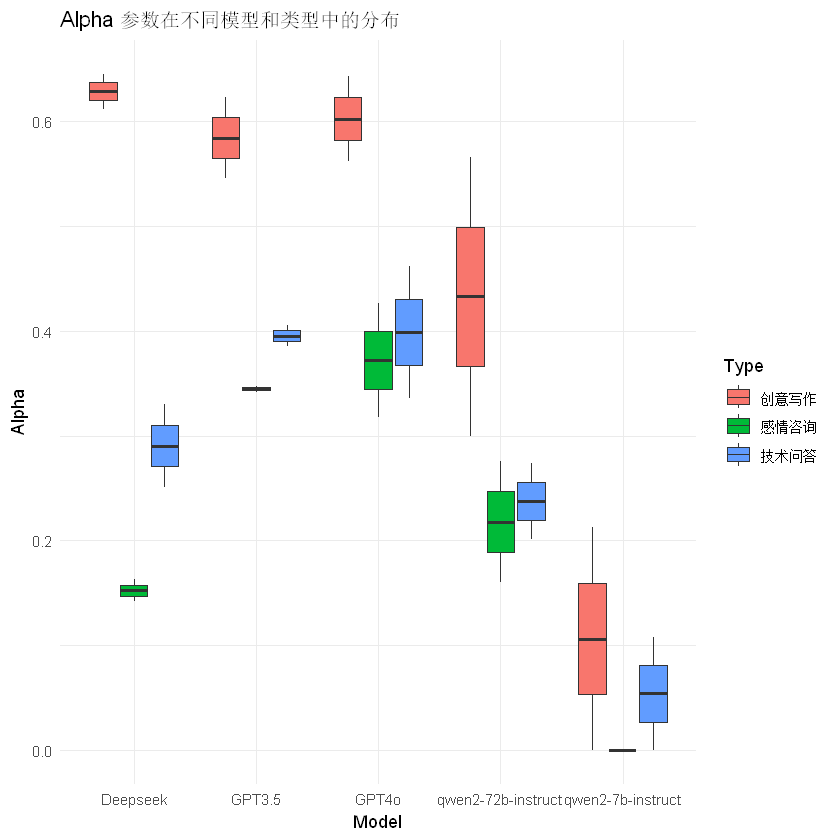

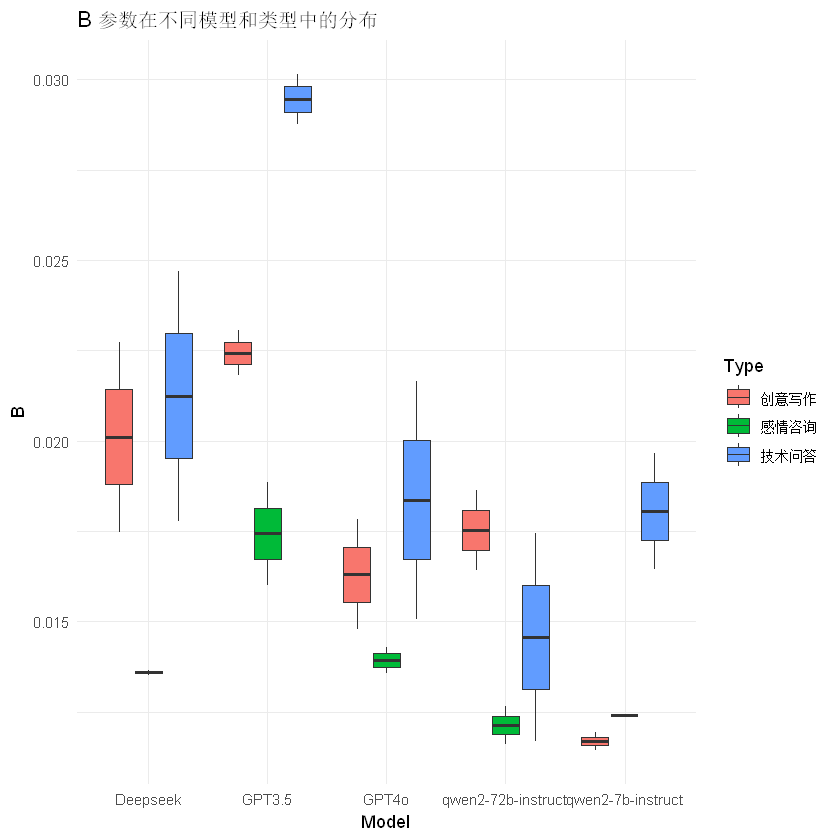

In [20]:
# 可视化 alpha 参数
ggplot(parameters, aes(x = Model, y = alpha, fill = Type)) +
  geom_boxplot() +
  labs(title = "Alpha 参数在不同模型和类型中的分布", x = "Model", y = "Alpha") +
  theme_minimal()

# 可视化 B 参数
ggplot(parameters, aes(x = Model, y = B, fill = Type)) +
  geom_boxplot() +
  labs(title = "B 参数在不同模型和类型中的分布", x = "Model", y = "B") +
  theme_minimal()


# 结果可视化

我们将结果可视化，展示 Zipf-Mandelbrot 分布。


`geom_smooth()` using formula = 'y ~ x'


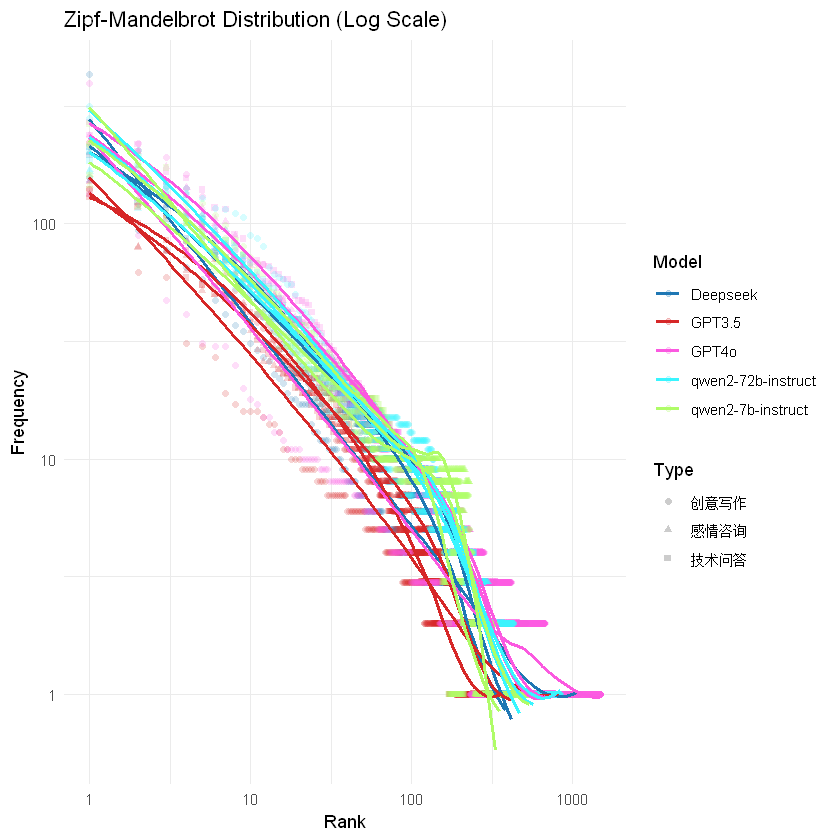

In [13]:
model_colors <- c("Deepseek" = "#1f77b4", "qwen2-72b-instruct" = "#39f5ff", "qwen2-7b-instruct" = "#affc68", "GPT4o" = "#fb59e0", "GPT3.5" = "#D62728")

ggplot(results, aes(x = Rank, y = Frequency, color = Model, shape = Type)) +
  geom_point(alpha = 0.2) +
  geom_smooth(se = FALSE, method = "loess") +
  scale_color_manual(values = model_colors) +
  labs(title = "Zipf-Mandelbrot Distribution (Log Scale)", x = "Rank", y = "Frequency") +
  theme_minimal() +
  theme(legend.position = "right") +
  scale_x_log10() +
  scale_y_log10()


# ANOVA 分析

我们将对结果进行 ANOVA 分析。


In [14]:
results <- results %>%
  mutate(Rank = as.numeric(Rank), Frequency = as.numeric(Frequency), Model = as.factor(Model), Type = as.factor(Type))

anova_model <- aov(Frequency ~ Rank * Model * Type, data = results)
anova_summary <- summary(anova_model)
print(anova_summary)


                   Df  Sum Sq Mean Sq F value   Pr(>F)    
Rank                1  498636  498636 2373.56  < 2e-16 ***
Model               4   42760   10690   50.89  < 2e-16 ***
Type                2    5209    2604   12.40 4.17e-06 ***
Rank:Model          4  190985   47746  227.28  < 2e-16 ***
Rank:Type           2  207855  103928  494.71  < 2e-16 ***
Model:Type          8   43586    5448   25.93  < 2e-16 ***
Rank:Model:Type     8   32900    4113   19.58  < 2e-16 ***
Residuals       16012 3363791     210                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


# 正态性检验

我们将对残差进行正态性检验。



	Lilliefors (Kolmogorov-Smirnov) normality test

data:  residuals
D = 0.24492, p-value < 2.2e-16



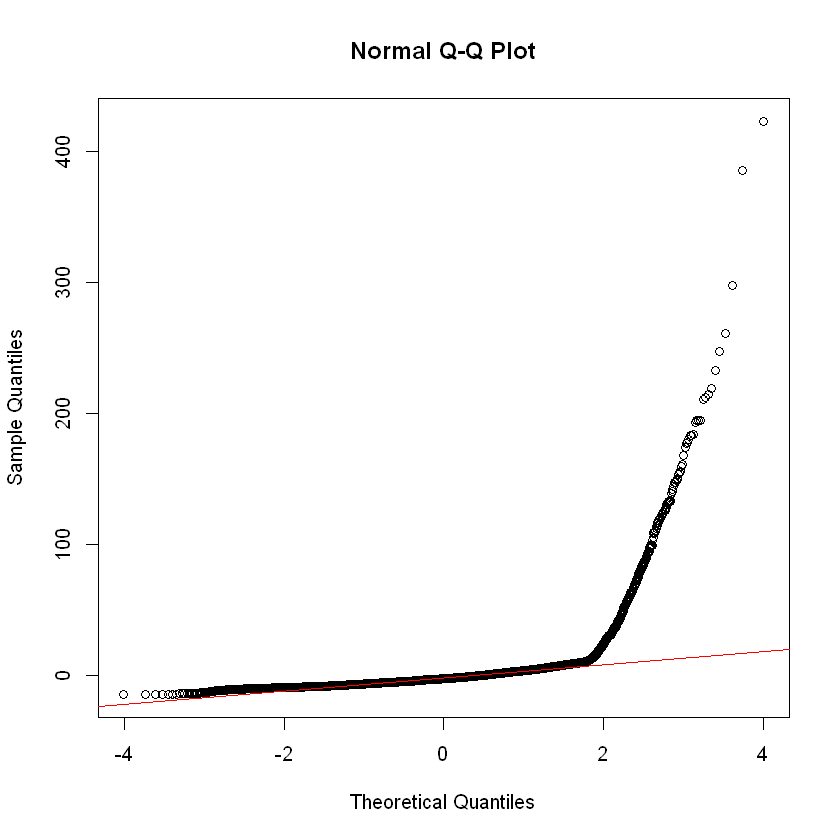

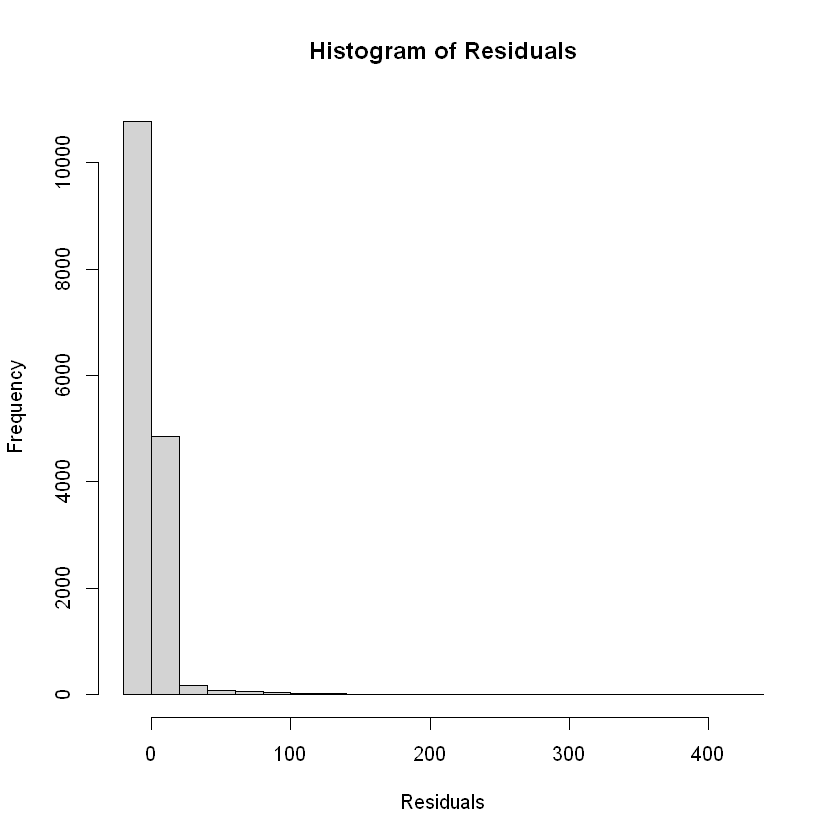

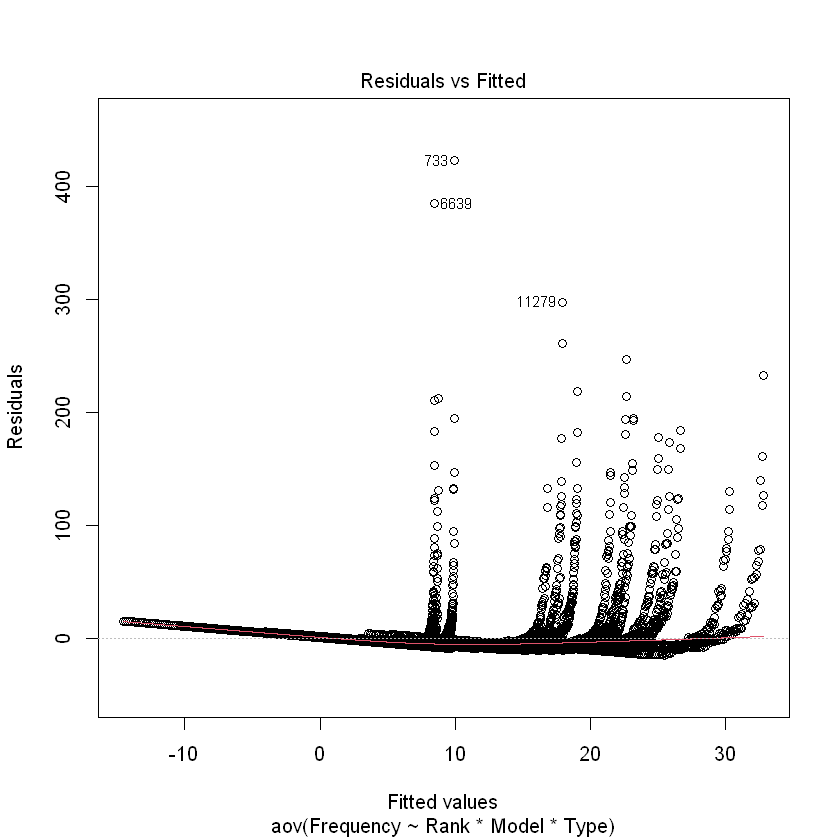

In [15]:
residuals <- residuals(anova_model)
ks_test <- lillie.test(residuals)
print(ks_test)

# 绘制正态性检验图
qqnorm(residuals)
qqline(residuals, col = "red")
hist(residuals, breaks = 30, main = "Histogram of Residuals", xlab = "Residuals")
plot(anova_model, which = 1)


# 进一步的可视化

我们将绘制箱线图和交互图，以进一步分析频率与模型和类型之间的关系。


`summarise()` has grouped output by 'Model'. You can override using the
`.groups` argument.
Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


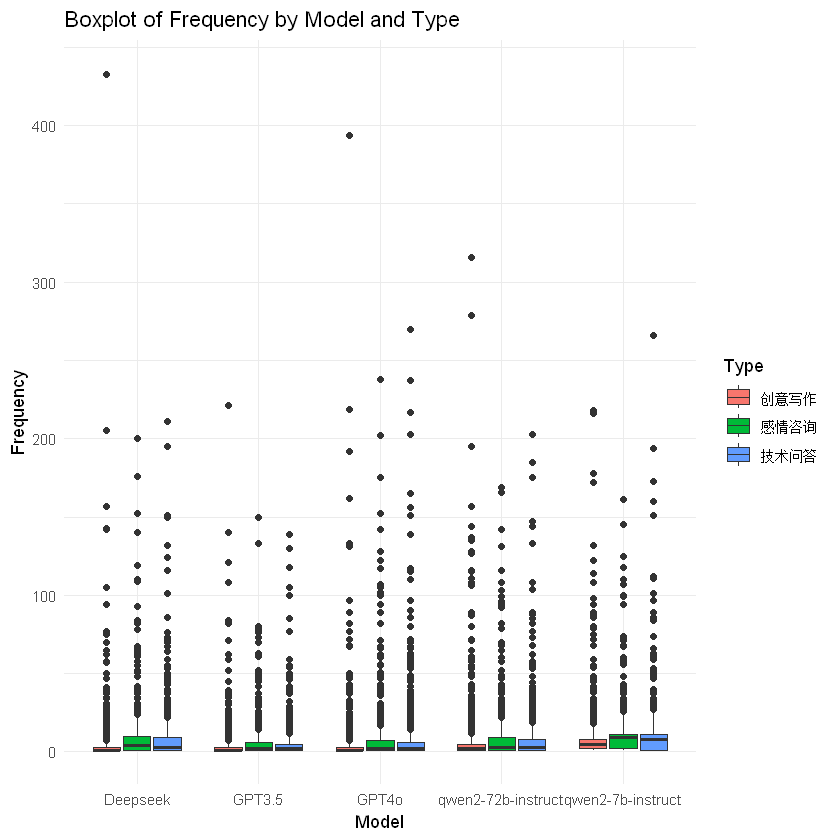

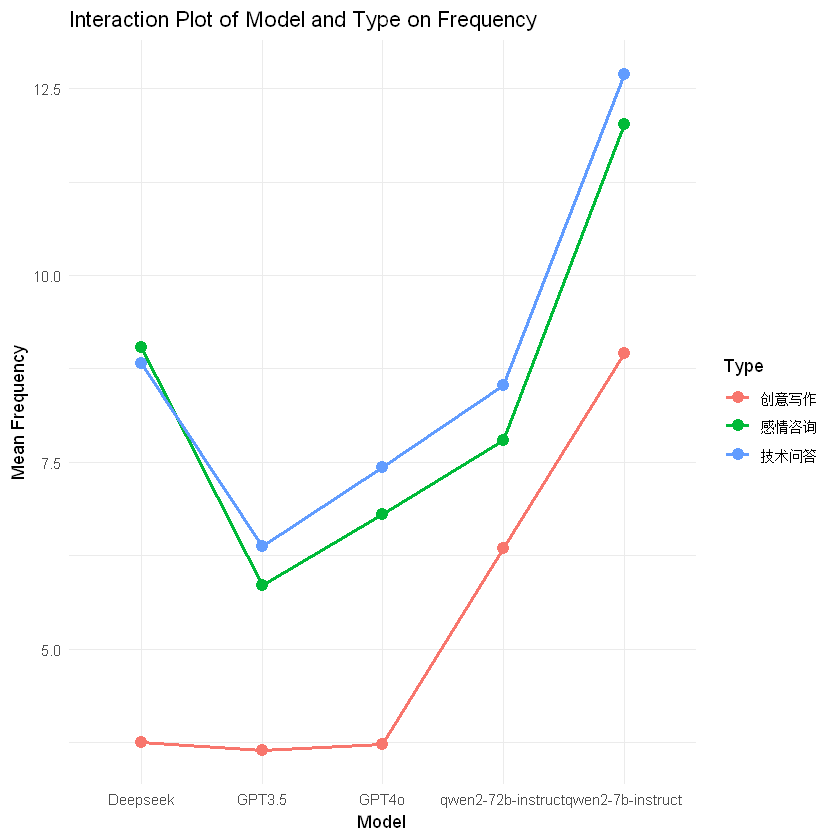

In [16]:
ggplot(results, aes(x = Model, y = Frequency, fill = Type)) +
  geom_boxplot() +
  labs(title = "Boxplot of Frequency by Model and Type", x = "Model", y = "Frequency") +
  theme_minimal()

interaction_data <- results %>%
  group_by(Model, Type) %>%
  summarise(mean_frequency = mean(Frequency))

ggplot(interaction_data, aes(x = Model, y = mean_frequency, color = Type, group = Type)) +
  geom_line(size = 1) +
  geom_point(size = 3) +
  labs(title = "Interaction Plot of Model and Type on Frequency", x = "Model", y = "Mean Frequency") +
  theme_minimal()


# 频率均值和误差条形图

我们将绘制带有误差条的频率均值图。


`summarise()` has grouped output by 'Model'. You can override using the
`.groups` argument.


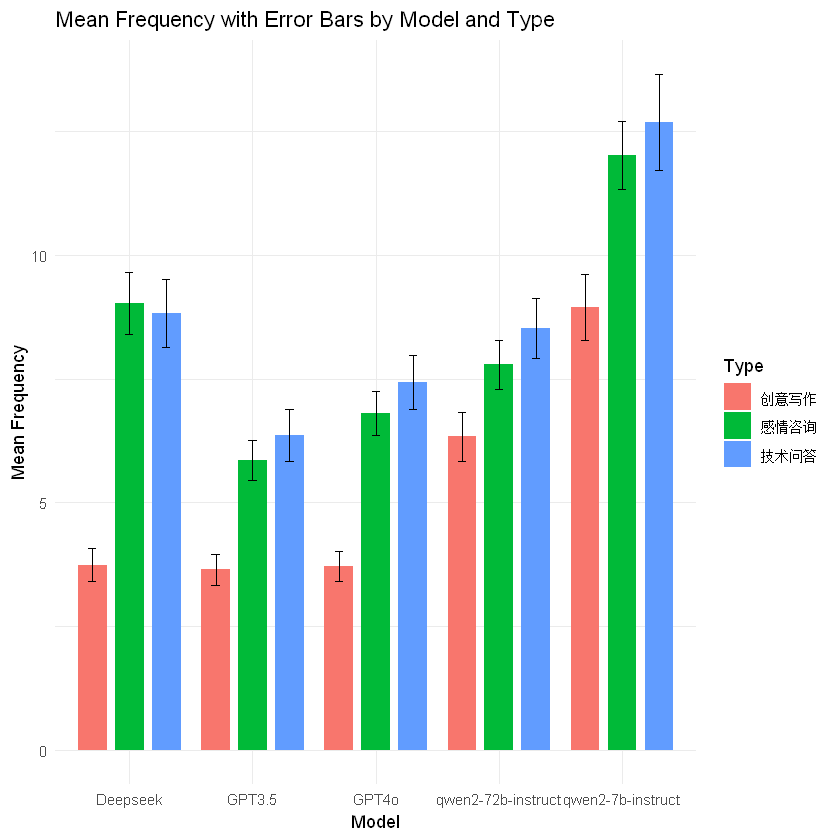

In [17]:
summary_data <- results %>%
  group_by(Model, Type) %>%
  summarise(mean_frequency = mean(Frequency), se_frequency = sd(Frequency) / sqrt(n()))

ggplot(summary_data, aes(x = Model, y = mean_frequency, fill = Type)) +
  geom_bar(stat = "identity", position = position_dodge(0.9), width = 0.7) +
  geom_errorbar(aes(ymin = mean_frequency - se_frequency, ymax = mean_frequency + se_frequency), width = 0.2, position = position_dodge(0.9)) +
  labs(title = "Mean Frequency with Error Bars by Model and Type", x = "Model", y = "Mean Frequency") +
  theme_minimal()
